In [109]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, TargetEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import spmatrix
from scipy.stats import loguniform, uniform, randint
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import re
sys.path.append(os.path.abspath("../"))
from src.data.load_data import load_dataset
sys.path.append(os.path.abspath("../src")) 
from src.features.preprocess import deterministic_fe
from src.utils.helpers import other_titles,get_personal_title, random_search_cv
from src.features.transformers import PersonalTitleTransformer
from src.features.pipe_config import preprocessing_pipeline
from src.utils.helpers import grid_search_res
from joblib import dump
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = load_dataset('../data/raw/train.csv')
test = load_dataset('../data/raw/test.csv')
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop('Survived', axis=1)
y_test = test['Survived']

In [4]:
X_trans = preprocessing_pipeline().fit_transform(X_train, y_train)
trans = pd.concat([X_trans, y_train], axis=1)

In [ ]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
Pipe = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('standardise', StandardScaler()),
    ('model',SVC(random_state=42))
])
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
cv = cross_validate(Pipe, 
                    X=X_train,
                    y=y_train, 
                    return_train_score=True,
                    cv=skf,
                    scoring=scoring
                    )


In [27]:
pd.DataFrame(cv).mean()#.to_excel('../reports/model_outputs/train/svc/base_svc.xlsx')

fit_time                    0.027206
score_time                  0.008413
test_accuracy               0.825618
train_accuracy              0.854431
test_precision_weighted     0.826372
train_precision_weighted    0.857033
test_recall_weighted        0.825618
train_recall_weighted       0.854431
test_f1_weighted            0.822730
train_f1_weighted           0.850956
dtype: float64

In [38]:
uniform(0,5)

In [ ]:
param_grid={'model__C':loguniform(0.001, 1000), #Małe C duze marginesy, Duze C male marginesy. Zakres low high na skali logarytmicznej wartosc x jest losowana tak, ze log(x) jest rownomiernie rozlozone. Przydatne dla parametrow, które dizalaj multiplikatywnie (C, gamma)
            'model__kernel': ['linear', 'poly','rbf'], 
            'model__degree': [3,4,5,6], 
            'model__coef0':uniform(0,5),#Kazda wartosc w tym zakresie jest rownie prawdopodobna. uzywa sie go gdy wartosci sa w jednej skali liniowej
            'model__gamma': loguniform(1e-3, 10)}#fajny bo losuje w skali logarytmicznej. gęściej przy malych wartościach rzadziej przy duzych
# Due to the cost of the computation i have decided to use randomized search 
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
}
rs = RandomizedSearchCV(Pipe, 
                  param_distributions=param_grid, 
                  scoring=scoring, 
                  refit='f1',
                  n_jobs=-1,
                  return_train_score=True,
                    verbose=1,
                    n_iter = 50,
                    )

rs.fit(X_train, y_train)

In [49]:
pd.DataFrame(rs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__kernel,param_model__gamma,param_model__degree,param_model__coef0,param_model__C,params,...,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1
0,0.058625,0.006799,0.024032,0.005001,rbf,0.010,3,0.0,1.00,"{'model__kernel': 'rbf', 'model__gamma': 0.01,...",...,0.786255,0.022776,14,0.800196,0.791408,0.797616,0.798263,0.788573,0.795211,0.004438
1,0.060725,0.005704,0.023770,0.002488,poly,0.010,4,0.5,100.00,"{'model__kernel': 'poly', 'model__gamma': 0.01...",...,0.812261,0.021329,7,0.879104,0.867715,0.871177,0.877073,0.881412,0.875296,0.005089
2,0.067109,0.005384,0.023198,0.004657,rbf,0.001,3,2.0,10.00,"{'model__kernel': 'rbf', 'model__gamma': 0.001...",...,0.780588,0.017947,28,0.800196,0.787872,0.784941,0.790474,0.782848,0.789266,0.006046
3,0.064032,0.001941,0.023620,0.005018,rbf,10.000,3,2.0,0.01,"{'model__kernel': 'rbf', 'model__gamma': 10, '...",...,0.473148,0.002142,43,0.474219,0.472872,0.472872,0.472872,0.472872,0.473141,0.000539
4,0.061911,0.017431,0.018451,0.007364,rbf,1.000,6,0.0,10.00,"{'model__kernel': 'rbf', 'model__gamma': 1, 'm...",...,0.751692,0.019683,33,0.957355,0.961110,0.961025,0.962897,0.955783,0.959634,0.002638
5,0.466890,0.217269,0.013920,0.003690,linear,0.100,3,0.0,100.00,"{'model__kernel': 'linear', 'model__gamma': 0....",...,0.785205,0.019407,16,0.782747,0.792126,0.784941,0.790474,0.803885,0.790835,0.007379
6,0.083317,0.016052,0.020953,0.006053,linear,1.000,4,0.0,10.00,"{'model__kernel': 'linear', 'model__gamma': 1,...",...,0.785205,0.019407,16,0.782747,0.792126,0.784941,0.790474,0.803885,0.790835,0.007379
7,0.051671,0.006123,0.020452,0.008158,linear,10.000,5,2.0,0.01,"{'model__kernel': 'linear', 'model__gamma': 10...",...,0.784974,0.019244,24,0.800196,0.788094,0.784941,0.792371,0.786668,0.790454,0.005456
8,0.057982,0.006381,0.017144,0.004385,rbf,10.000,5,0.5,10.00,"{'model__kernel': 'rbf', 'model__gamma': 10, '...",...,0.536689,0.022839,41,0.989427,0.985952,0.992964,0.987681,0.985915,0.988388,0.002629
9,0.052180,0.004107,0.018619,0.001224,rbf,10.000,3,2.0,100.00,"{'model__kernel': 'rbf', 'model__gamma': 10, '...",...,0.534573,0.029903,42,0.991201,0.989473,0.996482,0.992964,0.987692,0.991562,0.003021


In [ ]:
res_1_rs = pd.DataFrame(rs.cv_results_)
# res_1_rs.to_excel('../reports/model_outputs/train/svc/rs_1_res.xlsx')
res_1_rs[['params', 'mean_test_f1','mean_train_f1']].sort_values(by='mean_test_f1', ascending=False)

### Both rbf and poly kernels are similarly good with a small edge in test validation sets for poly kernel. What now?
- I will separate parameter optimiziation onto two separate models (one with RBF Kernel) (One with Poly kernel)

In [ ]:
param_grid={'model__C':loguniform(0.001, 1000), #Małe C duze marginesy, Duze C male marginesy. Zakres low high na skali logarytmicznej wartosc x jest losowana tak, ze log(x) jest rownomiernie rozlozone. Przydatne dla parametrow, które dizalaj multiplikatywnie (C, gamma)
            'model__kernel': ['linear', 'poly','rbf'], 
            'model__degree': [3,4,5,6], 
            'model__coef0':uniform(0,5),#Kazda wartosc w tym zakresie jest rownie prawdopodobna. uzywa sie go gdy wartosci sa w jednej skali liniowej
            'model__gamma': loguniform(1e-3, 10)}#fajny bo losuje w skali logarytmicznej. gęściej przy malych wartościach rzadziej przy duzych
# Due to the cost of the computation i have decided to use randomized search 
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
}
rs = RandomizedSearchCV(Pipe, 
                  param_distributions=param_grid, 
                  scoring=scoring, 
                  refit='f1',
                  n_jobs=-1,
                  return_train_score=True,
                    verbose=1,
                    n_iter = 50,
                    )

rs.fit(X_train, y_train)

In [100]:
for i in uniform(0.001,100).rvs(size=10):
    print(format(i, '.0f'))

65
40
50
33
42
10
26
19
1
56


In [ ]:
param_grid={'model__C':loguniform(0.001, 1000), #Małe C duze marginesy, Duze C male marginesy. Zakres low high na skali logarytmicznej wartosc x jest losowana tak, ze log(x) jest rownomiernie rozlozone. Przydatne dla parametrow, które dizalaj multiplikatywnie (C, gamma) 
            'model__degree': [3,4,5,6], 
            'model__coef0':uniform(0,5),#Kazda wartosc w tym zakresie jest rownie prawdopodobna. uzywa sie go gdy wartosci sa w jednej skali liniowej
            'model__gamma': loguniform(1e-3, 10)}

In [113]:
pipe_poly = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('standardise', StandardScaler()),
    ('model',SVC(random_state=42, kernel='poly'))
])
param_grid={'model__C':loguniform(0.001, 100), #Małe C duze marginesy, Duze C male marginesy. Zakres low high na skali logarytmicznej wartosc x jest losowana tak, ze log(x) jest rownomiernie rozlozone. Przydatne dla parametrow, które dizalaj multiplikatywnie (C, gamma) 
            'model__degree': randint(2,6), 
            'model__coef0':uniform(0,5),#Kazda wartosc w tym zakresie jest rownie prawdopodobna. uzywa sie go gdy wartosci sa w jednej skali liniowej
            'model__gamma': loguniform(1e-3, 10)}

rs_pol = random_search_cv(pipe_poly, param_grid)

In [114]:
rs_pol.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__C': <scipy.stats....t 0x337272cc0>, 'model__coef0': <scipy.stats....t 0x337270b00>, 'model__degree': <scipy.stats....t 0x34319c8f0>, 'model__gamma': <scipy.stats....t 0x337273920>}"
,n_iter,50
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_weighted', 'precision': 'precision_weighted', 'recall': 'recall_weighted'}"
,n_jobs,-1
,refit,'f1'
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [116]:
pd.DataFrame(rs_pol.cv_results_)
res_pol = pd.DataFrame(rs_pol.cv_results_)
# res_1_rs.to_excel('../reports/model_outputs/train/svc/rs_1_res.xlsx')
res_pol[['params', 'mean_test_f1','mean_train_f1']].sort_values(by='mean_test_f1', ascending=False)

,params,mean_test_f1,mean_train_f1
13,"{'model__C': 0.002881586861398977, 'model__coe...",0.828555,0.844365
5,"{'model__C': 0.33916422013589054, 'model__coef...",0.825195,0.836057
6,"{'model__C': 0.44339435533549654, 'model__coef...",0.824267,0.850766
39,"{'model__C': 0.0077970391506791345, 'model__co...",0.823699,0.848991
15,"{'model__C': 2.343371001811061, 'model__coef0'...",0.823341,0.841184
25,"{'model__C': 42.108080260679344, 'model__coef0...",0.822451,0.852017
20,"{'model__C': 4.129308209784631, 'model__coef0'...",0.821953,0.836298
3,"{'model__C': 0.003527884903346854, 'model__coe...",0.819306,0.866371
19,"{'model__C': 0.007969169788587931, 'model__coe...",0.818960,0.869945
14,"{'model__C': 0.00520603651507763, 'model__coef...",0.818533,0.822669


In [129]:
pipe_rbf = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('standardise', StandardScaler()),
    ('model',SVC(random_state=42, kernel='rbf'))
])
param_grid={'model__C':loguniform(0.001, 100), #Małe C duze marginesy, Duze C male marginesy. Zakres low high na skali logarytmicznej wartosc x jest losowana tak, ze log(x) jest rownomiernie rozlozone. Przydatne dla parametrow, które dizalaj multiplikatywnie (C, gamma) 
            'model__coef0':uniform(0,10),#Kazda wartosc w tym zakresie jest rownie prawdopodobna. uzywa sie go gdy wartosci sa w jednej skali liniowej
            'model__gamma': loguniform(1e-3, 10)}

rs_rbf = random_search_cv(pipe_rbf, param_grid, n_iter=1000)
rs_rbf.fit(X_train, y_train)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__C': <scipy.stats....t 0x3433edf10>, 'model__coef0': <scipy.stats....t 0x3378cf8c0>, 'model__gamma': <scipy.stats....t 0x3433ef830>}"
,n_iter,1000
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_weighted', 'precision': 'precision_weighted', 'recall': 'recall_weighted'}"
,n_jobs,-1
,refit,'f1'
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [131]:
res_rbf = pd.DataFrame(rs_rbf.cv_results_)
# res_1_rs.to_excel('../reports/model_outputs/train/svc/rs_1_res.xlsx')
res_rbf[['params', 'mean_test_f1','mean_train_f1']].sort_values(by=['mean_test_f1','mean_train_f1'], ascending=False)

,params,mean_test_f1,mean_train_f1
894,"{'model__C': 0.9430896392160073, 'model__coef0...",0.829620,0.840243
115,"{'model__C': 1.976937120141404, 'model__coef0'...",0.829607,0.844101
303,"{'model__C': 2.1221407789681552, 'model__coef0...",0.829607,0.843385
790,"{'model__C': 1.5081004489640135, 'model__coef0...",0.828276,0.842419
180,"{'model__C': 1.0547948639549956, 'model__coef0...",0.828067,0.839568
...,...,...,...
313,"{'model__C': 0.14221762724960738, 'model__coef...",0.472480,0.478633
171,"{'model__C': 0.10148948302522882, 'model__coef...",0.472480,0.477093
950,"{'model__C': 0.11395743673165437, 'model__coef...",0.472480,0.477093
97,"{'model__C': 0.15333369258134907, 'model__coef...",0.472480,0.476315


In [128]:
res_rbf[['params', 'mean_test_f1','mean_train_f1']].sort_values(by=['mean_test_f1','mean_train_f1'], ascending=False)

,params,mean_test_f1,mean_train_f1
283,"{'model__C': 0.9760241733608679, 'model__coef0...",0.830944,0.844994
529,"{'model__C': 0.5174678103906237, 'model__coef0...",0.830240,0.836720
325,"{'model__C': 1.6298718240737617, 'model__coef0...",0.829607,0.844480
310,"{'model__C': 1.8674170775557102, 'model__coef0...",0.829607,0.844101
706,"{'model__C': 1.1275786110142216, 'model__coef0...",0.829607,0.843428
...,...,...,...
493,"{'model__C': 0.10478713835285133, 'model__coef...",0.472480,0.478633
776,"{'model__C': 0.12240274552251013, 'model__coef...",0.472480,0.477093
177,"{'model__C': 0.1585012489779563, 'model__coef0...",0.472480,0.475531
19,"{'model__C': 0.09715647139622749, 'model__coef...",0.472480,0.474740


In [ ]:
best_params = res_rbf[['params', 'mean_test_f1','mean_train_f1']].sort_values(by=['mean_test_f1','mean_train_f1'], ascending=False).iloc[1]['params']
best_params

{'model__C': np.float64(0.5174678103906237),
 'model__coef0': np.float64(4.999360780145911),
 'model__degree': 2,
 'model__gamma': np.float64(0.07096086061283641)}

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       109
           1       0.76      0.77      0.76        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.81       178
weighted avg       0.82      0.81      0.81       178



['../reports/model_outputs/train/svc/best_svc.pkl']

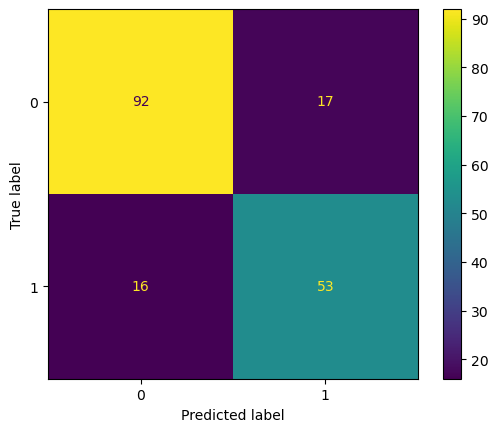

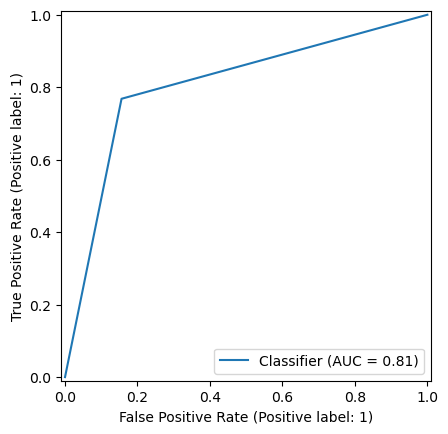

In [140]:
### FINAL MODEL 

pipe_rbf = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('standardise', StandardScaler()),
    ('model',SVC(random_state=42, 
                 kernel='rbf', 
                 C=0.5174678103906237,
                 gamma=0.07096086061283641))
])

pipe_rbf.fit(X_train, y_train)

preds = pipe_rbf.predict(X_test)

print(classification_report(y_test, preds))
ConfusionMatrixDisplay.from_predictions(y_test, preds)
RocCurveDisplay.from_predictions(y_test, preds)

dump(pipe_rbf,'../reports/model_outputs/train/svc/best_svc.pkl')